In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

In [2]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

In [3]:
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

In [4]:
weight_diagonal = x_vals.std(0)
weight_matrix = tf.cast(tf.diag(weight_diagonal), dtype=tf.float32)

In [5]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]
k = 4
batch_size=len(x_vals_test)

In [6]:
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [7]:
subtraction_term =  tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))
first_product = tf.matmul(subtraction_term, tf.tile(tf.expand_dims(weight_matrix,0), [batch_size,1,1]))
second_product = tf.matmul(first_product, tf.transpose(subtraction_term, perm=[0,2,1]))
distance = tf.sqrt(tf.matrix_diag_part(second_product))

In [8]:
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)
top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), squeeze_dims=[1])

In [9]:
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

In [10]:
num_loops = int(np.ceil(len(x_vals_test)/batch_size))
for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

Batch #1 MSE: 25.513


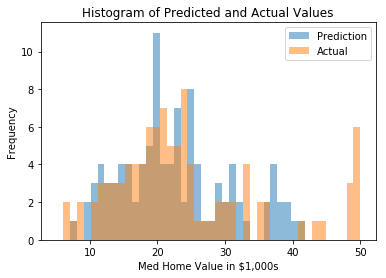

In [11]:
bins = np.linspace(5, 50, 45)
plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()